In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

### Helper Functions

In [2]:
# row cleaners
## only to be called on df with format: city, value, city, value, ...
def row_clean_skip_1(df):
    estimate_index = list(range(1, df.shape[0], 2))
    city_index = list(range(0, df.shape[0], 2))

    df_city = df.iloc[city_index]["City"]
    df_vals = df.iloc[estimate_index].drop("City", axis= 1)
    df_vals["City"] = df_city.values
    return df_vals

## only to be called on df with format: city, blank, value, city, blank, value, ...
def row_clean_skip_2(df):
    percent_index = list(range(2, df.shape[0], 3))
    city_index = list(range(0, df.shape[0], 3))
    
    df_percent = df.iloc[percent_index].drop("City", axis= 1)
    df_city = df.iloc[city_index]["City"]
    df_percent["City"] = df_city.values
    
    return df_percent

In [3]:
# Only take the name of the city
city_types = ["city", "town", "CDP", "borough", "County", "municipality", "village", "urbana"]
city_dict = {}
# creates a dict for cleaned names and maintain index order
def clean_city_names(df):
    for i in city_types:
        city_cln = df.loc[df.City.str.contains(i)].City.apply(lambda x: re.split(i, x, flags=re.IGNORECASE)[0])
        for j in range(len(city_cln.index)):
            city_dict[city_cln.index[j]] = city_cln.values[j]
    # sort dict for index order
    sorted_city = dict(sorted(city_dict.items()))
    df.City = pd.Series(sorted_city)
    return df

In [4]:
# check for nan values in columns
def check_na(df):
    for i in df.columns:
        na_vals = df[i].loc[df[i].isna()].index.values
        print(i + str(na_vals))

### Crime Data

In [5]:
# Clean up column names
crime_cols = ["State", "City", "Population", "Violent_Crime", "Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault", "Property_Crime", "Burglary", "Larceny_Theft", "Vehicle_Theft", "Arson"]
df_crime_city_state = pd.read_excel("data/Offenses_known_by_city_state.xls", header=3, names=crime_cols)

In [6]:
# drop state column
df_crime_city = df_crime_city_state.drop("State", axis=1)

# drop footnotes for the data
footer_rows = df_crime_city[df_crime_city.City.isna()].index.values
df_crime = df_crime_city.drop(index=footer_rows)

# replace nan values in crime type columns
#check_na(df_crime)
crime_type_cols = ["Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault", "Burglary", "Larceny_Theft", "Vehicle_Theft", "Arson"]
for i in crime_type_cols:
    df_crime[i] = df_crime[i].fillna(0)
df_crime.Violent_Crime = df_crime[["Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault"]].sum(axis=1)
df_crime.Property_Crime = df_crime[["Burglary", "Larceny_Theft", "Vehicle_Theft", "Arson"]].sum(axis=1)

# create column for total, violent, and property crime rate
df_crime["Crime_Rate"] = (df_crime.Violent_Crime + df_crime.Property_Crime) / df_crime.Population
df_crime["Violent_Crime_Rate"] = df_crime.Violent_Crime / df_crime.Population
df_crime["Property_Crime_Rate"] = df_crime.Property_Crime / df_crime.Population
# dropping rows with no population recorded and excess columns
no_pop = df_crime.loc[df_crime.Population.isna()].index.values
df_crime_pop = df_crime.drop(no_pop)
cln_df_crime = df_crime_pop.drop(["Murder_Manslaughter", "Rape", "Robbery", "Aggravated_Assault", "Arson",
                                  "Burglary", "Larceny_Theft", "Vehicle_Theft", "Violent_Crime", "Property_Crime"], axis=1)
check_na(cln_df_crime)
cln_df_crime

City[]
Population[]
Crime_Rate[]
Violent_Crime_Rate[]
Property_Crime_Rate[]


,City,Population,Crime_Rate,Violent_Crime_Rate,Property_Crime_Rate
0,Hoover,85670.0,0.023789,0.001331,0.022458
1,Anchorage,287731.0,0.055382,0.012446,0.042936
2,Bethel,6544.0,0.041870,0.019866,0.022005
3,Bristol Bay Borough,852.0,0.025822,0.002347,0.023474
4,Cordova,2150.0,0.003256,0.000000,0.003256
...,...,...,...,...,...
8100,Sheridan,17895.0,0.021291,0.000503,0.020788
8101,Thermopolis5,2830.0,0.016608,0.004594,0.012014
8102,Torrington,6709.0,0.009092,0.001938,0.007155
8103,Wheatland,3544.0,0.022291,0.001975,0.020316


### Law Enforcement Data

In [7]:
# clean up column names
law_cols = ["State", "City", "Population", "Total_Law_Enforcement", "Total_Officers", "Total_Civilians"]
df_law = pd.read_excel("data/Law_enforcement_by_city_state.xls", header=3, names=law_cols)

In [8]:
# drop state column
df_law_dropped = df_law.drop("State", axis=1)

# drop footnotes for the data
df_law_footer = df_law_dropped.drop(index=len(df_law_dropped) -1)

# remove the footer notation 
df_law_footer.City.str.replace("\d+", "", regex=True)

# replacing nan values
#check_na(df_law_footer)
df_law_footer.Population = df_law_footer.Population.fillna(0)

# find percentage of law enforcement workers to population
df_law_footer["Enforcement_Rate"] = df_law_footer.Total_Law_Enforcement / df_law_footer.Population

cln_df_law = df_law_footer.drop(["Population", "Total_Officers", "Total_Civilians"], axis=1)
check_na(cln_df_law)
cln_df_law

City[]
Total_Law_Enforcement[]
Enforcement_Rate[]


,City,Total_Law_Enforcement,Enforcement_Rate
0,Abbeville,14.0,0.005495
1,Adamsville,28.0,0.006509
2,Addison,4.0,0.005548
3,Alabaster,89.0,0.002647
4,Albertville,69.0,0.003193
...,...,...,...
8945,Sundance,3.0,0.002335
8946,Thermopolis,13.0,0.004594
8947,Torrington,25.0,0.003726
8948,Wheatland,9.0,0.002540


### Employment Rate Data

In [9]:
employ_cols = ["City", "Total_Labour_Force", "Employed", "Unemployed"]
df_employ = pd.read_csv("data/Employment_Rate.csv", names=employ_cols, header= 0)

In [10]:
# shift the variable columns up one and remove the estimate rows
df_employ_shifted = row_clean_skip_1(df_employ)

# clean City names
df_employ_city = clean_city_names(df_employ_shifted)

# nan cases
df_employ_cln = df_employ_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_employ_cln = df_employ_cln.replace(to_replace={"Unemployed": "[^.0-9]", 
                                                    "Total_Labour_Force": "[^.0-9]"},
                             value= {"Unemployed": "", 
                                     "Total_Labour_Force": ""},
                             regex= True)
df_employ_cln.Unemployed = df_employ_cln.Unemployed.astype("float64")
df_employ_cln.Total_Labour_Force = df_employ_cln.Total_Labour_Force.astype("float64")



# unemployment rate
df_employ_cln["Unemployment_Rate"] = df_employ_cln["Unemployed"] / df_employ_cln["Total_Labour_Force"]
cln_unemploy_df = df_employ_cln[["City", "Unemployment_Rate"]]
check_na(cln_unemploy_df)
cln_unemploy_df

City[]
Unemployment_Rate[]


,City,Unemployment_Rate
1,Alabaster,0.054431
3,Albertville,0.010814
5,Anniston,0.045324
7,Athens,0.014845
9,Auburn,0.036191
...,...,...
4657,Mayagüez zona,0.248215
4659,Ponce zona,0.099934
4661,San Juan zona,0.178230
4663,Trujillo Alto zona,0.032412


### Median Earnings Data

In [11]:
df_earn = pd.read_csv("data/Median_Earnings.csv", names= ["City", "Median_Earnings"], header= 0)

In [12]:
# shift earnings
df_earn_shifted = row_clean_skip_1(df_earn)

# clean city names
df_earn_cln = clean_city_names(df_earn_shifted)

# nan cases
#check_na(df_earn_cln)
df_earn_cln2 = df_earn_cln.dropna(axis=0, how="any")

# convert median to float
df_earn_cln2.Median_Earnings = df_earn_cln2.Median_Earnings.replace(to_replace= ",", value= "", regex=True)
df_earn_cln2.Median_Earnings = df_earn_cln2.Median_Earnings.astype("float64")
# reorder columns
cln_df_earn = df_earn_cln2[["City", "Median_Earnings"]]
check_na(cln_df_earn)
cln_df_earn

City[]
Median_Earnings[]


,City,Median_Earnings
1,Alabaster,37408.0
3,Albertville,25837.0
5,Anniston,29635.0
7,Athens,38209.0
9,Auburn,24009.0
...,...,...
4657,Mayagüez zona,15446.0
4659,Ponce zona,16576.0
4661,San Juan zona,21345.0
4663,Trujillo Alto zona,20361.0


### Housing Data

In [13]:
housing_cols = ["City", "Total_Housing", "Total_Occupied", "Total_Vacant"]
df_housing = pd.read_csv("data/Occupancy_of_Housing.csv", names= housing_cols, header= 0)

In [14]:
# shift housing
df_housing_shifted = row_clean_skip_1(df_housing)
# clean city names
df_housing_city = clean_city_names(df_housing_shifted)
# nan cases
df_housing_cln = df_housing_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_housing_cln2 = df_housing_cln.replace(to_replace={"Total_Housing": "[^.0-9]", "Total_Occupied": "[^.0-9]", "Total_Vacant": "[^.0-9]"},
                             value= {"Total_Housing": "", "Total_Occupied": "", "Total_Vacant": ""},
                             regex= True)
df_housing_cln2["Total_Housing"] = df_housing_cln2["Total_Housing"].astype("float64")
df_housing_cln2["Vacancy_Rate"] = df_housing_cln2.Total_Vacant.astype(float) / df_housing_cln2.Total_Housing
# drop columns
cln_housing_df = df_housing_cln2[["City", "Vacancy_Rate", "Total_Housing"]]
check_na(cln_housing_df)
cln_housing_df

City[]
Vacancy_Rate[]
Total_Housing[]


,City,Vacancy_Rate,Total_Housing
1,Alabaster,0.048378,12547.0
3,Albertville,0.027536,7917.0
5,Anniston,0.191638,12414.0
7,Athens,0.140883,11648.0
9,Auburn,0.086413,28630.0
...,...,...,...
4657,Mayagüez zona,0.312487,34283.0
4659,Ponce zona,0.193180,55047.0
4661,San Juan zona,0.270850,185778.0
4663,Trujillo Alto zona,0.199262,19512.0


### Poverty Data

In [15]:
poverty_cols = ["City", "Population", "Extreme_Poverty", "Poverty"]
df_poverty = pd.read_csv("data/Poverty_ratio.csv", names= poverty_cols, header= 0)

In [16]:
# shift cols
df_poverty_shifted = row_clean_skip_1(df_poverty)
df_poverty_city = clean_city_names(df_poverty_shifted)
# nan cases
#check_na(df_poverty_cln)
df_poverty_cln = df_poverty_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_poverty_cln2 = df_poverty_cln.replace(to_replace={"Population": "[^.0-9]", "Extreme_Poverty": "[^.0-9]", "Poverty": "[^.0-9]"},
                             value= {"Population": "", "Extreme_Poverty": "", "Poverty": ""},
                             regex= True)
df_poverty_cln2["Poverty_Rate"] = (df_poverty_cln2.Extreme_Poverty.astype(float) + df_poverty_cln2.Poverty.astype(float)) / df_poverty_cln2.Population.astype(float)

# drop columns

cln_poverty_df = df_poverty_cln2[["City", "Poverty_Rate"]]
check_na(cln_poverty_df)
cln_poverty_df

City[]
Poverty_Rate[]


,City,Poverty_Rate
1,Alabaster,0.034122
3,Albertville,0.143708
5,Anniston,0.283622
7,Athens,0.179552
9,Auburn,0.261113
...,...,...
4657,Mayagüez zona,0.535846
4659,Ponce zona,0.508098
4661,San Juan zona,0.400007
4663,Trujillo Alto zona,0.258239


### Health Insurance Data

In [17]:
priv_cols = ["City", "Population", "With_Priv", "No_Priv"]
pub_cols = ["City", "Population", "With_Pub", "No_Pub"]
df_priv = pd.read_csv("data/Private_health_insurance.csv", names= priv_cols, header= 0)
df_pub = pd.read_csv("data/Public_health_insurance.csv", names= pub_cols, header= 0)

In [18]:
# shift cols
df_priv_shifted = row_clean_skip_1(df_priv)
df_pub_shifted = row_clean_skip_1(df_pub)

# combine dataframes
df_pub_shifted["With_Priv"] = df_priv_shifted.With_Priv
# clean city names
df_pub_city = clean_city_names(df_pub_shifted)

# check na 
# heck_na(df_pub_cln)
df_pub_cln = df_pub_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_pub_cln2 = df_pub_cln.replace(to_replace={"Population": "[^.0-9]", "With_Pub": "[^.0-9]", "With_Priv": "[^.0-9]"},
                             value= {"Population": "", "With_Pub": "", "With_Priv": ""},
                             regex= True)
df_pub_cln2["Pub_Health_Rate"] = df_pub_cln2.With_Pub.astype(float) / df_pub_cln2.Population.astype(float)
df_pub_cln2["Priv_Health_Rate"] = df_pub_cln2.With_Priv.astype(float) / df_pub_cln2.Population.astype(float)
cln_health_df = df_pub_cln2[["City", "Pub_Health_Rate", "Priv_Health_Rate"]]
check_na(cln_health_df)
cln_health_df

City[]
Pub_Health_Rate[]
Priv_Health_Rate[]


,City,Pub_Health_Rate,Priv_Health_Rate
1,Alabaster,0.258749,0.759877
3,Albertville,0.385887,0.550548
5,Anniston,0.503219,0.530111
7,Athens,0.351986,0.812879
9,Auburn,0.144547,0.885790
...,...,...,...
4657,Mayagüez zona,0.654782,0.349054
4659,Ponce zona,0.676414,0.332448
4661,San Juan zona,0.501695,0.495030
4663,Trujillo Alto zona,0.465397,0.593211


### Education

In [19]:
educ_cols = ["City","Population", "No_HS_Diploma", "HS_Grad", "B_Grad", "Grad+/Pro"]
df_educ = pd.read_csv("data/educ_levels.csv", names= educ_cols, header= 0)

In [20]:
# shift columns
df_educ_shifted = row_clean_skip_1(df_educ)

# clean city names
df_educ_city = clean_city_names(df_educ_shifted)
# nan cases
#check_na(df_educ_cln)
df_educ_cln = df_educ_city.dropna(axis=0, how="any")

# remove commas to convert to float
df_educ_cln2 = df_educ_cln.replace(to_replace={"Population": "[^.0-9]", "Grad+/Pro": "[^.0-9]", "B_Grad": "[^.0-9]",
                                               "HS_Grad": "[^.0-9]", "No_HS_Diploma": "[^.0-9]"},
                             value= {"Population": "","Grad+/Pro": "", "B_Grad": "", "HS_Grad": "", "No_HS_Diploma": ""},
                             regex= True)
educ_float = df_educ_cln2.drop("City", axis= 1).astype(float)
educ_float["City"] = df_educ_cln2.City
educ_float["Uni_or_Pro"] = educ_float.B_Grad + educ_float["Grad+/Pro"]
educ_float["Grad+/Pro_Rate"] = educ_float.Uni_or_Pro / educ_float.Population
cln_educ_df = educ_float[["City", "Grad+/Pro_Rate", "HS_Grad", "No_HS_Diploma"]]
check_na(cln_educ_df)
cln_educ_df

City[]
Grad+/Pro_Rate[]
HS_Grad[]
No_HS_Diploma[]


,City,Grad+/Pro_Rate,HS_Grad,No_HS_Diploma
1,Alabaster,0.358300,5496.0,934.0
3,Albertville,0.199138,4693.0,2140.0
5,Anniston,0.228403,4987.0,1904.0
7,Athens,0.316840,5735.0,2090.0
9,Auburn,0.666667,3490.0,582.0
...,...,...,...,...
4657,Mayagüez zona,0.323512,9788.0,2338.0
4659,Ponce zona,0.333676,21714.0,5276.0
4661,San Juan zona,0.406771,47183.0,12873.0
4663,Trujillo Alto zona,0.411557,5747.0,1172.0


## Combine all data frames

In [24]:
city_vals = [cln_educ_df, cln_df_earn, cln_unemploy_df, cln_df_crime,cln_housing_df, cln_df_law, cln_poverty_df, cln_health_df]
initial_df = pd.DataFrame(cln_df_earn.City)

# clean city columns for merging
for df in city_vals:
    df.City = df.City.astype("string").str.strip().str.lower()
    df.City = df.City.apply(lambda x: re.sub(r'\s+', ' ', x))
    df = df.drop_duplicates(subset=["City"])
    initial_df = pd.merge(initial_df, df, how="left", on= "City")
    
# drop any potential duplicates
initial_df = initial_df.drop_duplicates(subset=["City"])

# drop cities with unknown data
final_df = initial_df.dropna(axis=0, how="any")
final_df.reset_index(drop= True, inplace= True)

In [25]:
final_df

,City,Grad+/Pro_Rate,HS_Grad,No_HS_Diploma,Median_Earnings,Unemployment_Rate,Population,Crime_Rate,Violent_Crime_Rate,Property_Crime_Rate,Vacancy_Rate,Total_Housing,Total_Law_Enforcement,Enforcement_Rate,Poverty_Rate,Pub_Health_Rate,Priv_Health_Rate
0,athens,0.316840,5735.0,2090.0,38209.0,0.014845,1913.0,0.005750,0.001045,0.004705,0.140883,11648.0,56.0,0.002087,0.179552,0.351986,0.812879
1,auburn,0.666667,3490.0,582.0,24009.0,0.036191,14201.0,0.020562,0.003521,0.017041,0.086413,28630.0,150.0,0.002225,0.261113,0.144547,0.885790
2,birmingham,0.295397,43461.0,13748.0,30014.0,0.073028,21479.0,0.006378,0.000466,0.005913,0.177401,113421.0,1023.0,0.004880,0.251868,0.436455,0.530731
3,decatur,0.251752,12858.0,2754.0,32065.0,0.056615,1813.0,0.034749,0.009377,0.025372,0.112543,24755.0,151.0,0.002792,0.146167,0.379581,0.631620
4,florence,0.269841,8425.0,3187.0,22546.0,0.051155,26385.0,0.004472,0.001668,0.002805,0.150321,21341.0,132.0,0.003256,0.220114,0.386620,0.622856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,casper,0.218440,12664.0,1771.0,34240.0,0.021244,57752.0,0.031999,0.002926,0.029073,0.105067,26307.0,144.0,0.002493,0.114556,0.305023,0.683957
1268,cheyenne,0.310111,12548.0,1488.0,36692.0,0.022711,64501.0,0.034573,0.003411,0.031162,0.058396,30704.0,126.0,0.001953,0.099151,0.299144,0.783535
1269,gillette,0.138023,7828.0,949.0,42644.0,0.011316,31960.0,0.020995,0.001345,0.019650,0.116574,14746.0,80.0,0.002503,0.093146,0.205234,0.786750
1270,laramie,0.604470,2612.0,317.0,22382.0,0.067740,32669.0,0.011693,0.001775,0.009918,0.121260,15075.0,75.0,0.002296,0.213673,0.226612,0.756659


### Analysis

<Figure size 6000x3000 with 0 Axes>

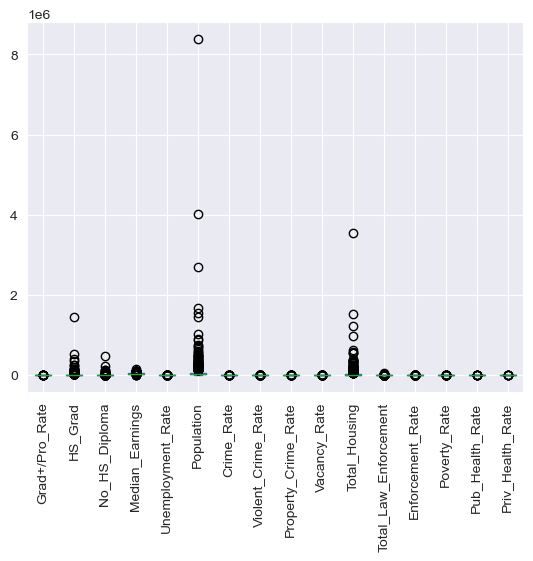

In [26]:
plt.figure(figsize=(20, 10), dpi= 300)
final_df.plot(kind="box", rot= 90)
plt.show()

In [27]:
final_df[["City", "Population"]].sort_values(by = "Population" , ascending=False)

,City,Population
900,new york,8379043.0
172,los angeles,4015546.0
489,chicago,2707064.0
29,phoenix,1688722.0
1132,san antonio,1559166.0
...,...,...
1240,martinsburg,297.0
689,norwood,295.0
540,st. charles,208.0
842,sparks,170.0


In [28]:
final_df[["City", "Total_Housing"]].sort_values(by = "Total_Housing", ascending=False)

,City,Total_Housing
900,new york,3546601.0
172,los angeles,1532364.0
489,chicago,1218078.0
1111,houston,987158.0
29,phoenix,637511.0
...,...,...
914,boone,5845.0
84,bloomington,5817.0
140,greenfield,5190.0
105,corcoran,4435.0


In [29]:
final_df.Crime_Rate.sort_values(ascending=False)

158     25.625000
1232     0.171731
1060     0.124412
293      0.090440
382      0.085036
          ...    
652      0.000000
689      0.000000
1093     0.000000
1240     0.000000
1176     0.000000
Name: Crime_Rate, Length: 1272, dtype: float64

<Axes: >

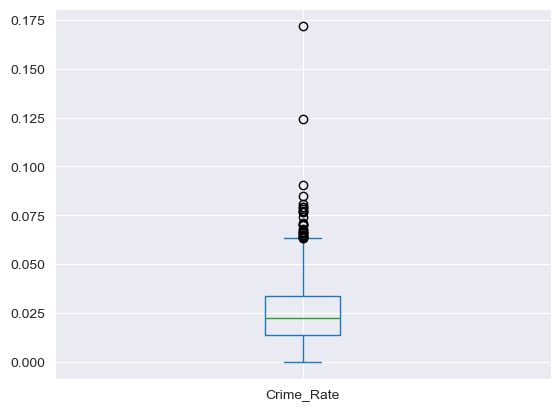

In [30]:
final_df = final_df.drop(158)
final_df.Crime_Rate.plot(kind= "box")

<Axes: ylabel='Frequency'>

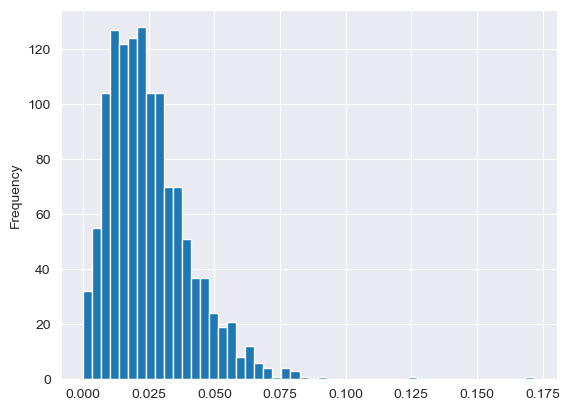

In [31]:
final_df.Crime_Rate.plot(kind= "hist", bins=50)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

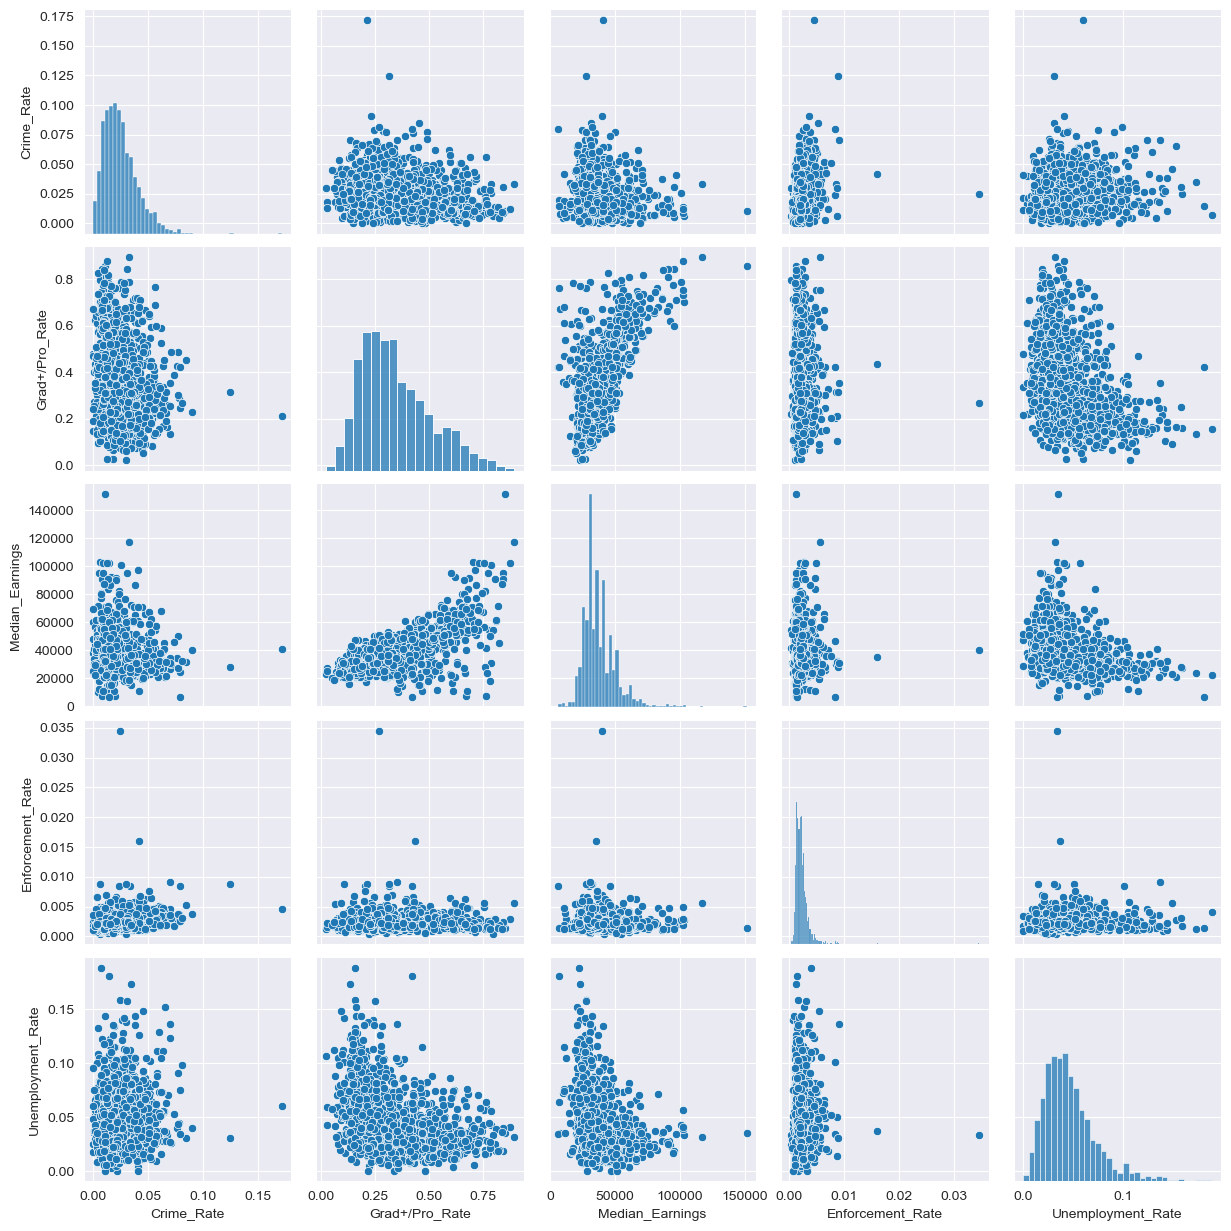

In [32]:
# checking for high relations between factors typically stated to be related to crime rate
sns.pairplot(final_df, vars= ["Crime_Rate", "Grad+/Pro_Rate", "Median_Earnings", "Enforcement_Rate", "Unemployment_Rate"])

<Axes: >

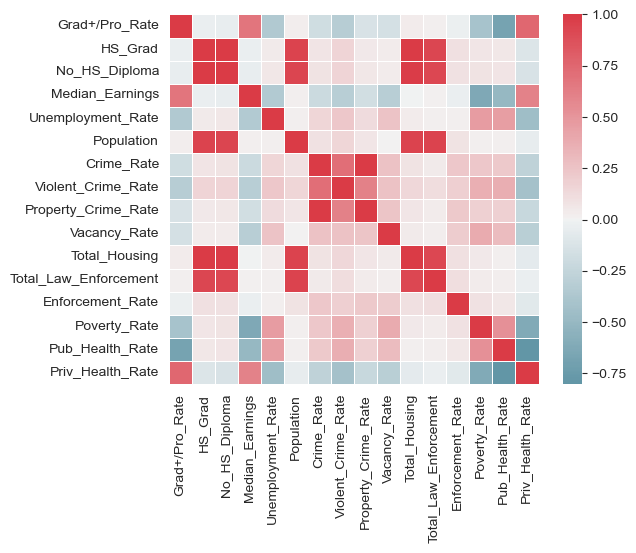

In [42]:
# creating a heatmap to find potential collinearity issues
cont_vals = final_df.drop("City", axis= 1).columns
corr = final_df[cont_vals].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, center=0, cmap= cmap, square=True, linewidths=.5)

In [35]:
# drop highly correlated variables 
final_df2 = final_df.drop(["Total_Housing", "Total_Law_Enforcement", "Violent_Crime_Rate", "Property_Crime_Rate"], axis= 1)

<Axes: >

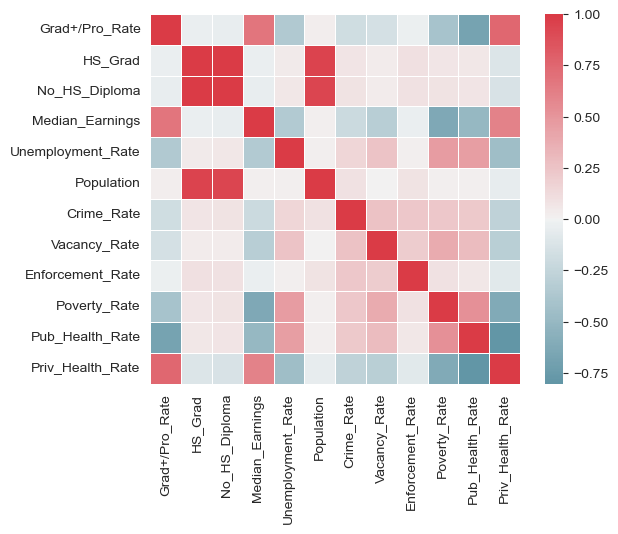

In [36]:
# checking heatmap again
cont_vals = final_df2.drop("City", axis= 1).columns
corr = final_df2[cont_vals].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, center=0, cmap= cmap, square=True, linewidths=.5)

In [38]:
final_df2.to_csv("final_df.csv", index= False)